# Project: Forecasting Real Estate Prices and Investment Comparison NYC vs Jersey City

**Business Objective**: Identify the top ZIP codes in NYC and Jersey City for real estate investment by forecasting housing prices using time series modeling.

## Data Load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## Bring in the housing price data and narrow it down to just NYC and Jersey City

In [84]:
file = "Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"
df = pd.read_csv(file)
df = df[df['City'].isin(['New York', 'Jersey City'])]


## Reshape data into long time series format 


In [130]:
date_cols = df.columns[10:]
df_long = df.melt(id_vars=['RegionName', 'City'], value_vars=date_cols,
                  var_name='date', value_name='price')
df_long['date'] = pd.to_datetime(df_long['date'])
df_long.dropna(inplace=True)

## Pivot so each ZIP is a column, with rows tracking prices over time

In [86]:
pivot = df_long.pivot(index='date', columns='RegionName', values='price')


## Top ZIP Codes by 3-Year Home Price Growth (Post Pandemic)

In [ ]:
latest = pivot.index.max()
past = latest - pd.DateOffset(years=3)
growth = ((pivot.loc[latest] / pivot.loc[past]) - 1) * 100
top_zip = growth.sort_values(ascending=False).head(5)

## Forecasting where prices might go for those fast growing ZIPs


In [ ]:
forecast_months = 12
min_length = 24
cutoff = pivot.index.max() - pd.DateOffset(years=3)

clean_zip_data = {}

for zip_code in pivot.columns:
    ts = pivot[zip_code]
    ts = ts.asfreq('ME')
    ts_clean = ts.interpolate().dropna()
    ts_recent = ts_clean[ts_clean.index >= cutoff]

    if len(ts_recent) >= min_length:
        clean_zip_data[zip_code] = ts_recent

latest = pivot.index.max()
past = latest - pd.DateOffset(years=3)

growth = {
    zip_code: (ts.loc[latest] / ts.loc[past] - 1) * 100
    for zip_code, ts in clean_zip_data.items()
    if past in ts.index and latest in ts.index
}

top_5_zip = sorted(growth.items(), key=lambda x: x[1], reverse=True)[:5]
ts_clean_dict = {zip_code: clean_zip_data[zip_code] for zip_code, _ in top_5_zip}

## Decompose time series into trend, seasonality, and residuals

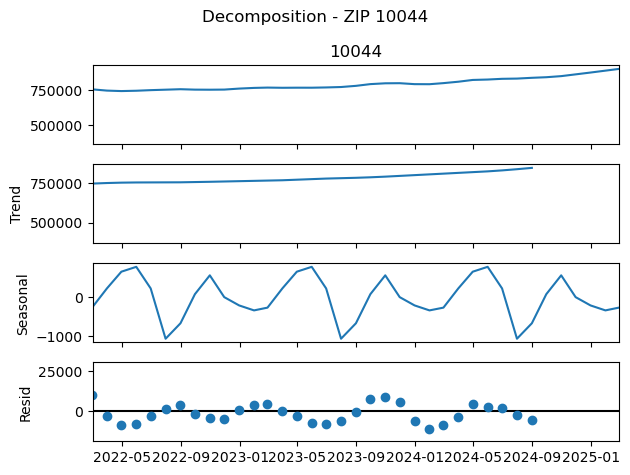

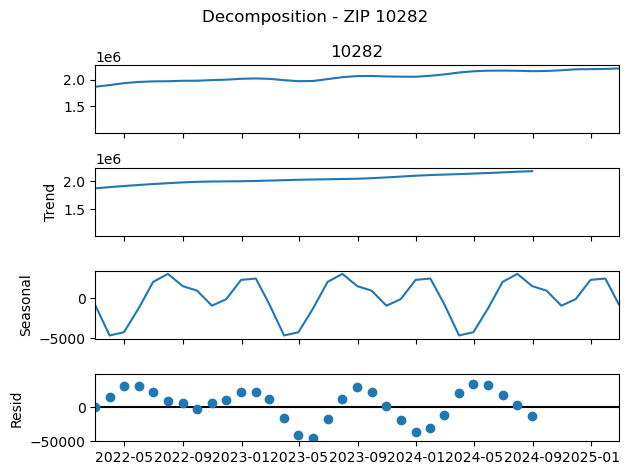

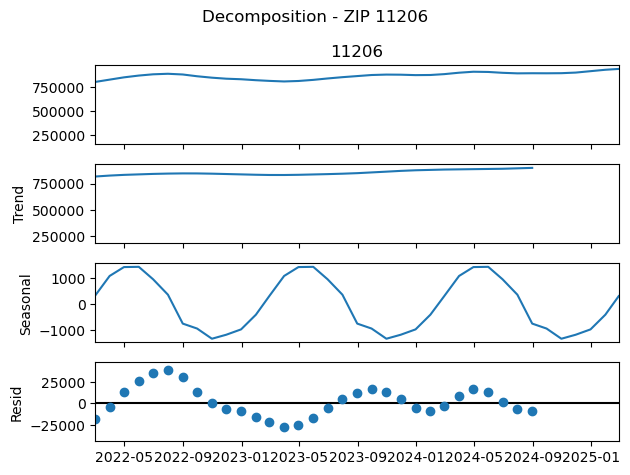

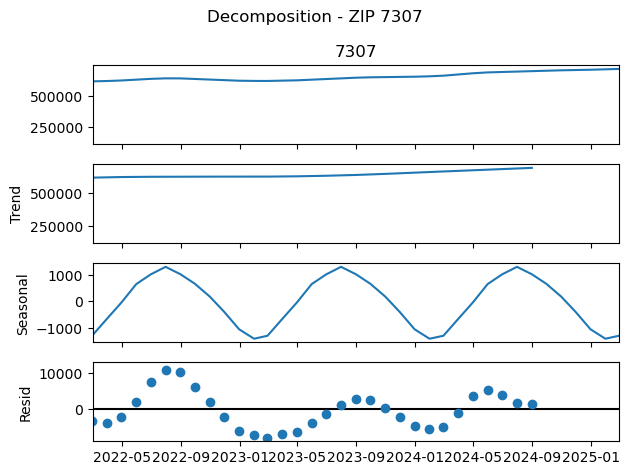

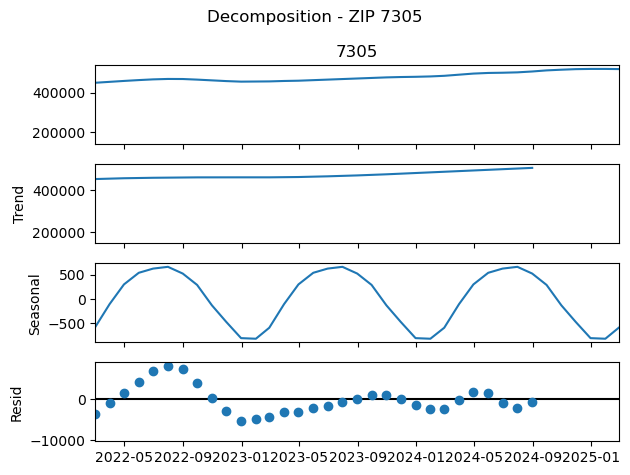

In [120]:
for zip_code, ts_clean in ts_clean_dict.items():
    try:
        decomp = seasonal_decompose(ts_clean, model='additive', period=12)
        fig = decomp.plot()
        fig.suptitle(f"Decomposition - ZIP {zip_code}")

        x_start = pd.Timestamp('2022-03-01')
        for ax in fig.axes:
            ax.set_xlim(x_start, ts_clean.index[-1])

        plt.tight_layout()
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Decomposition failed for ZIP {zip_code}: {e}")


## Use ARIMA to forecast the next 12 months

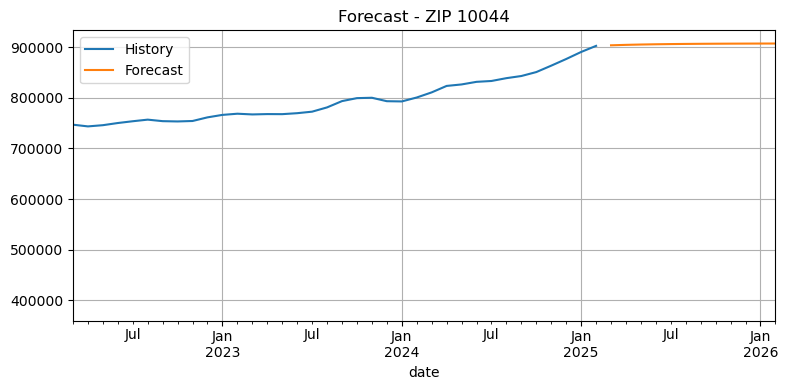

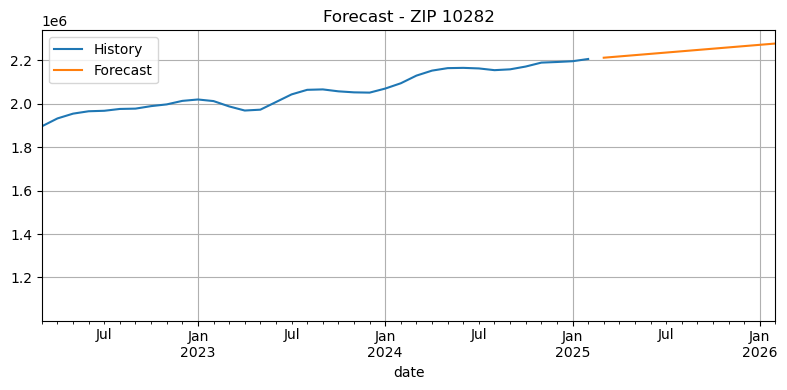

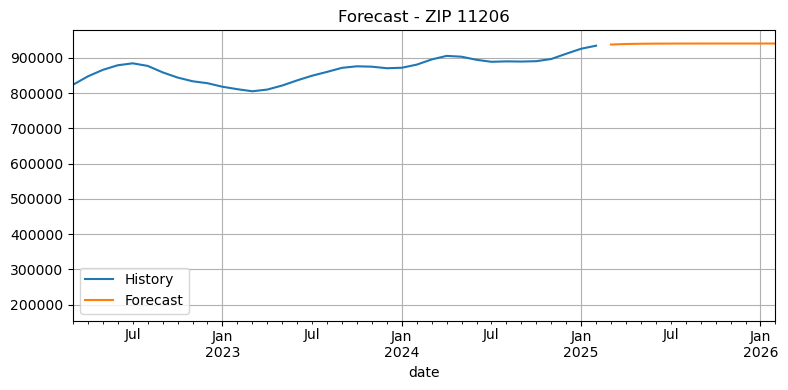

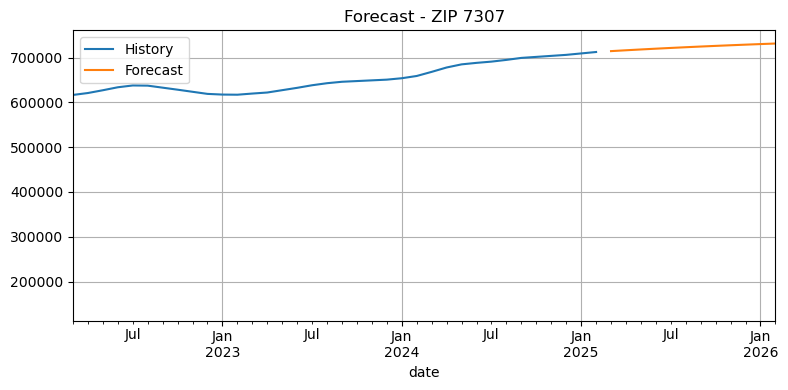

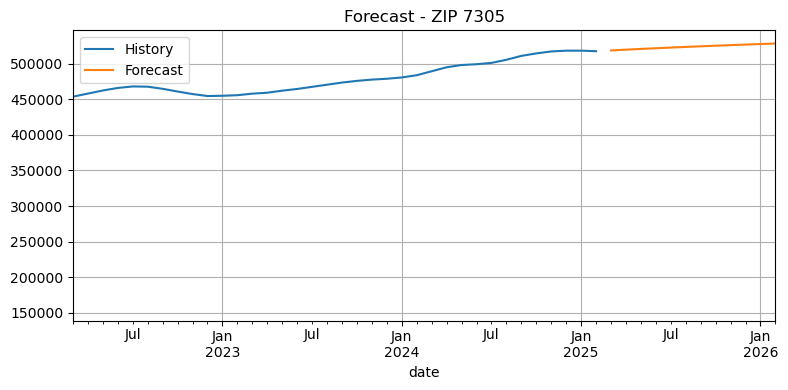

In [122]:
results = {}

for zip_code, ts_clean in ts_clean_dict.items():
    try:
        model = ARIMA(ts_clean, order=(1, 1, 1)).fit()
        forecast = model.forecast(steps=forecast_months)
        forecast.index = pd.date_range(
            start=ts_clean.index[-1] + pd.DateOffset(months=1),
            periods=forecast_months,
            freq='ME'
        )

        x_start = pd.Timestamp('2022-03-01')  
        plt.figure(figsize=(8, 4))
        ts_clean.plot(label='History')
        forecast.plot(label='Forecast')
        plt.xlim(x_start, forecast.index[-1])
        plt.title(f"Forecast - ZIP {zip_code}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.close()

        results[zip_code] = {'history': ts_clean, 'forecast': forecast}

    except Exception as e:
        print(f"ARIMA failed for ZIP {zip_code}: {e}")

## Showing past prices with the forecast added on

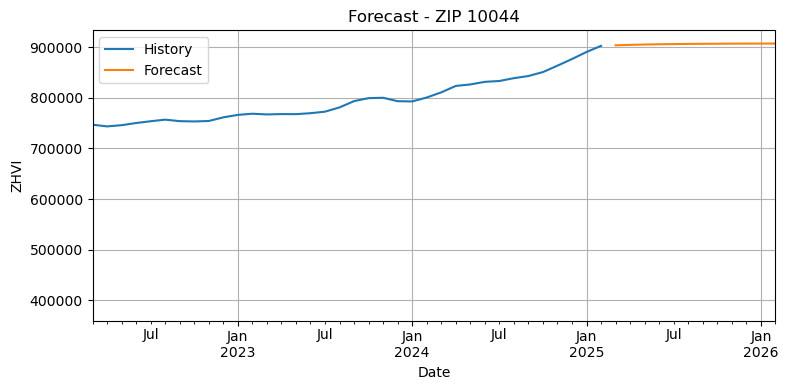

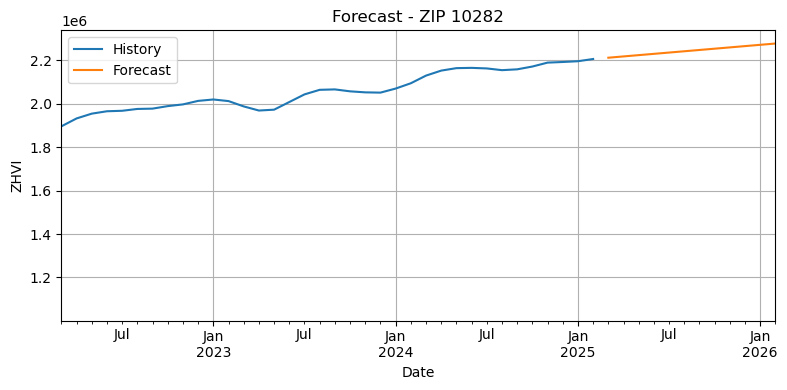

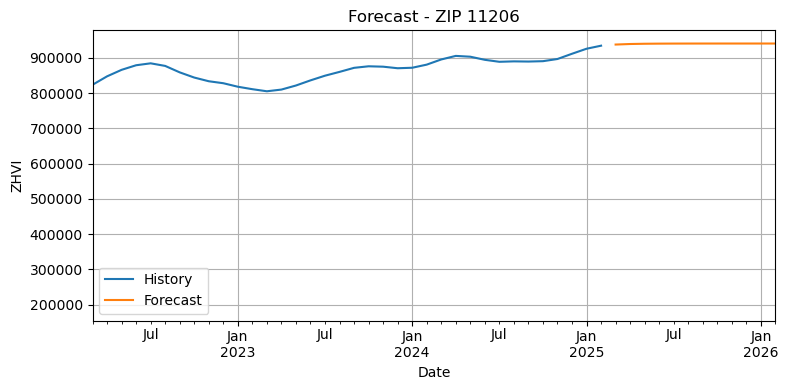

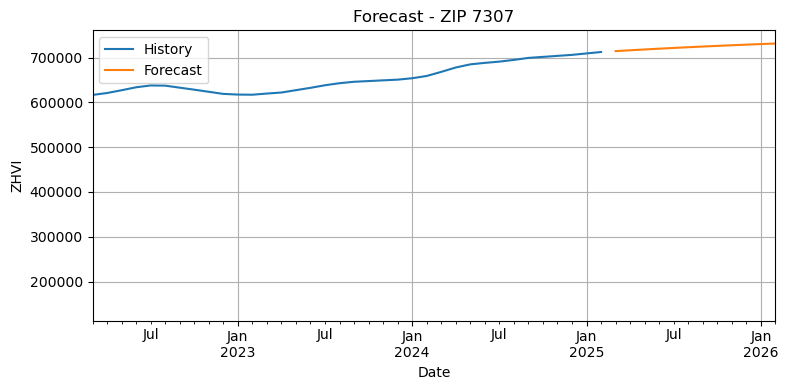

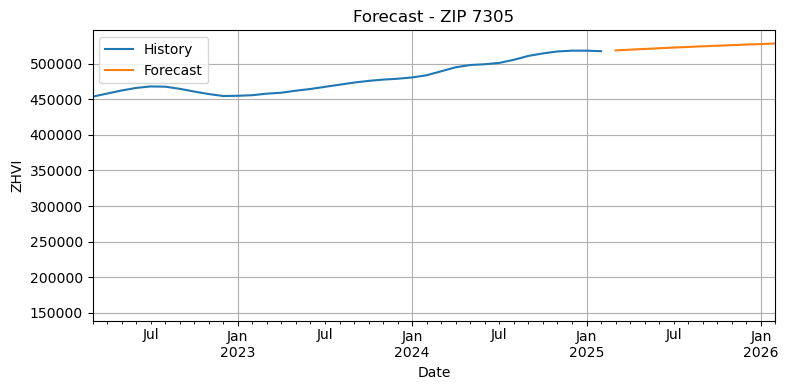

In [123]:
x_start = pd.Timestamp("2022-03-01")

for zip_code, ts_clean in ts_clean_dict.items():
    forecast = results[zip_code]["forecast"]

    plt.figure(figsize=(8, 4))
    ts_clean.plot(label="History")
    forecast.plot(label="Forecast")
    plt.xlim(x_start, forecast.index[-1])
    plt.title(f"Forecast - ZIP {zip_code}")
    plt.xlabel("Date")
    plt.ylabel("ZHVI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()


## Based on forecasts, calculate how much return someone might get over a year

In [127]:
returns = {}

for zip_code, f in results.items():
    try:
        current = f['history'].iloc[-1]
        future = f['forecast'].iloc[-1]

        if np.isfinite(current) and np.isfinite(future) and current > 0 and future > 0:
            rtn = round(((future / current) - 1) * 100, 2)
            returns[zip_code] = rtn
        else:
            print(f"Skipped ZIP {zip_code} due to invalid values")
    except Exception as e:
        print(f"Skipped ZIP {zip_code} due to error: {e}")

print("Predicted 1Y Returns by ZIP Code:")
for zip_code, rtn in returns.items():
    print(f"  ZIP {zip_code}: {rtn}%")

Predicted 1Y Returns by ZIP Code:
  ZIP 10044: 0.51%
  ZIP 10282: 3.23%
  ZIP 11206: 0.66%
  ZIP 7307: 2.66%
  ZIP 7305: 2.08%


## 1-Year Return Table (Ranked)

In [128]:
if returns:
    final = pd.DataFrame({
        'ZIP Code': list(returns.keys()),
        '1Y Return (%)': list(returns.values())
    }).sort_values(by='1Y Return (%)', ascending=False).reset_index(drop=True)
else:
    final = pd.DataFrame(columns=['ZIP Code', '1Y Return (%)'], dtype=object)

print("\nFinal Sorted Return Table:")
print(final)



Final Sorted Return Table:
   ZIP Code  1Y Return (%)
0     10282           3.23
1      7307           2.66
2      7305           2.08
3     11206           0.66
4     10044           0.51
